In [195]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Initial Data Loading
path_parent = os.path.dirname(os.getcwd()) 
path = os.path.join(path_parent, "data", "tgv_data.csv")
df = pd.read_csv(path, delimiter=';')
df = df.reset_index(drop=True)

# Data Preprocessing
commentaire_columns = [com for com in df.columns if 'commentaire' in com]
df.drop(columns=commentaire_columns, inplace=True)
df['year'] = df['date'].apply(lambda x: int(x.split('-')[0]))
df['month'] = df['date'].apply(lambda x: int(x.split('-')[1]))
df_encoded = pd.get_dummies(df, columns=['gare_depart', 'gare_arrivee'])
cols_for_cluster_assignment = ['year', 'month', 'duree_moyenne'] + [col for col in df_encoded.columns if 'gare_' in col]

# Split Data
df = df_encoded.sample(frac=1, random_state=1)  
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Clustering
numeric_cols = [
    'duree_moyenne', 'nb_train_prevu', 'nb_annulation',
    'nb_train_depart_retard', 'retard_moyen_depart',
    'nb_train_retard_arrivee', 'retard_moyen_arrivee',
    'nb_train_retard_sup_15', 'retard_moyen_trains_retard_sup15',
    'nb_train_retard_sup_30', 'nb_train_retard_sup_60',
    'prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic',
    'prct_cause_materiel_roulant', 'prct_cause_gestion_gare',
    'prct_cause_prise_en_charge_voyageurs'
]

data_for_clustering = train[numeric_cols].copy()
scaler = StandardScaler()
train[numeric_cols] = scaler.fit_transform(train[numeric_cols].copy())
data_for_clustering_normalized = scaler.fit_transform(data_for_clustering)

kmeans = KMeans(n_clusters=4, random_state=42)
train['cluster'] = kmeans.fit_predict(data_for_clustering_normalized)





c:\Users\arthu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [196]:
# Train Random Forest for each cluster
random_forest_models = {}
for cluster_num in train['cluster'].unique():
    cluster_data = train_encoded[train_encoded['cluster'] == cluster_num]
    X = cluster_data[cols_for_cluster_assignment]
    y = cluster_data['retard_moyen_arrivee']
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    random_forest_models[cluster_num] = rf

# Train Random Forest for cluster prediction
X_train = train[cols_for_cluster_assignment]
y_train = train.cluster
RF_to_estimate_cluster = RandomForestRegressor(n_estimators=100, random_state=42)
RF_to_estimate_cluster.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [197]:
# Test
test['predicted_cluster'] = RF_to_estimate_cluster.predict(test[cols_for_cluster_assignment])
test['predicted_cluster'] = test['predicted_cluster'].apply(round).astype(int)
scaler = StandardScaler()
test[numeric_cols] = scaler.fit_transform(test[numeric_cols].copy())

se, taille = 0, 0
for index, row in test.iterrows():
    X = row[cols_for_cluster_assignment].values.reshape(1, -1)  # Reshape data to 2D array
    cluster_label = row['predicted_cluster']
    y = row['retard_moyen_arrivee']
    
    predictor = random_forest_models[cluster_label]
    y_predict = predictor.predict(X)
    sqrd_error = (y_predict - y)**2
    se += sqrd_error
    taille += 1

mse = se/taille
mse

c:\Users\arthu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\arthu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\arthu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\arthu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\arthu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid fea

array([4386.21116903])

# Ancien code

In [152]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

path_parent = os.path.dirname(os.getcwd()) 
path = os.path.join(path_parent, "data", "tgv_data.csv")
df = pd.read_csv(path, delimiter=';')
df = df.reset_index(drop=True)

#df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
#df['mois'] = df['date'].dt.month
#df['annee'] = df['date'].dt.year

list_feature = ['gare_depart','gare_arrivee','service','duree_moyenne']
list_prct_cause = ['prct_cause_externe','prct_cause_infra','prct_cause_gestion_trafic','prct_cause_materiel_roulant','prct_cause_gestion_gare','prct_cause_prise_en_charge_voyageurs']
list_retard = ['retard_moyen_tous_trains_arrivee','retard_moyen_depart','retard_moyen_trains_retard_sup15','retard_moyen_arrivee']
list_nbr_test_en_retard = ['nb_train_prevu','nb_annulation','nb_train_depart_retard','nb_train_retard_arrivee','nb_train_retard_sup_15','nb_train_retard_sup_30','nb_train_retard_sup_60']

cols = list_feature + list_retard



## Preprocessing
#### One Hot Encoding sur Gare
#### Commentaire Oui/Non
#### DropNa()
#### Standardize
## ClusterLabel
#### Cluster non supervisé => ClusterLabel avec toutes les features
#### RandomForest pour classification supervisé vers ClusterLabel à partir de features_always_known
## Prédiction avec XGBoost sur features_always_known
#### XGBoost sur chaque cluster avec features_always_known
#### Prédiction avec Pipeline : RF->ClusterLabel->XGBoost_cluster_label_correspondant

In [153]:
# Importations nécessaires
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


# Préparation des données pour le clustering
numeric_cols = [
    'duree_moyenne', 'nb_train_prevu', 'nb_annulation',
    'nb_train_depart_retard', 'retard_moyen_depart',
    'nb_train_retard_arrivee', 'retard_moyen_arrivee',
    'nb_train_retard_sup_15', 'retard_moyen_trains_retard_sup15',
    'nb_train_retard_sup_30', 'nb_train_retard_sup_60',
    'prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic',
    'prct_cause_materiel_roulant', 'prct_cause_gestion_gare',
    'prct_cause_prise_en_charge_voyageurs'
]

# Prétraitement des données pour la prédiction
commentaire_columns = [com for com in df.columns if 'commentaire' in com]
df.drop(columns=commentaire_columns, inplace=True)
df['year'] = df['date'].apply(lambda x: int(x.split('-')[0]))
df['month'] = df['date'].apply(lambda x: int(x.split('-')[1]))
df_encoded = pd.get_dummies(df, columns=['gare_depart', 'gare_arrivee'])
cols_for_cluster_assignment = ['year', 'month', 'duree_moyenne'] + [col for col in df_encoded.columns if 'gare_' in col]


### Split Train Test
df = df_encoded.sample(frac=1, random_state=1)  

train, test = train_test_split(df, test_size=0.2, random_state=42)


data_for_clustering = train[numeric_cols].copy()
scaler = StandardScaler()

train[numeric_cols] = scaler.fit_transform(train[numeric_cols].copy())
data_for_clustering_normalized = scaler.fit_transform(data_for_clustering)


# Clustering avec KMeans et Création du ClusterLabel
kmeans = KMeans(n_clusters=4, random_state=42)
train['cluster'] = kmeans.fit_predict(data_for_clustering_normalized)


# Entraînement des modèles RandomForest pour chaque cluster
random_forest_models = {}
for cluster_num in train['cluster'].unique():
    cluster_data = train_encoded[train_encoded['cluster'] == cluster_num]
    X = cluster_data[cols_for_cluster_assignment]
    y = cluster_data['retard_moyen_arrivee']
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    random_forest_models[cluster_num] = rf


c:\Users\arthu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [154]:
X_train = train[cols_for_cluster_assignment]
y_train = train.cluster
RF_to_estimate_cluster = RandomForestRegressor(n_estimators=100, random_state=42)
RF_to_estimate_cluster.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [155]:
## Test
test['predicted_cluster'] = RF_to_estimate_cluster.predict(test[cols_for_cluster_assignment])
test['predicted_cluster'] = test['predicted_cluster'].apply(round).astype(int)


scaler = StandardScaler()
test[numeric_cols] = scaler.fit_transform(test[numeric_cols].copy())

In [156]:
predictor = random_forest_models[row.predicted_cluster]
X = row[cols_for_cluster_assignment]
X

year                                   2022
month                                     7
duree_moyenne                      0.727061
gare_depart_AIX EN PROVENCE TGV           0
gare_depart_ANGERS SAINT LAUD             0
                                     ...   
gare_arrivee_TOURCOING                    0
gare_arrivee_TOURS                        0
gare_arrivee_VALENCE ALIXAN TGV           0
gare_arrivee_VANNES                       0
gare_arrivee_ZURICH                       0
Name: 6752, Length: 121, dtype: object

In [157]:
se, taille = 0, 0
for index, row in test.iterrows():
    X = row[cols_for_cluster_assignment]
    cluster_label = row['predicted_cluster']
    y = row['retard_moyen_arrivee']
    
    predictor = random_forest_models[cluster_label]
    y_predict = predictor.predict(X)
    sqrd_error = (y_predict - y)**2
    se += sqrd_error
    taille += 1

mse = se/taille
mse

c:\Users\arthu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=[2.0220000e+03 7.0000000e+00 7.2706056e-01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [158]:

#predicted_cluster = kmeans.predict(scaler.transform(new_trajet[numeric_cols]))
#predicted_delay = random_forest_models[predicted_cluster[0]].predict(new_trajet[cols_for_cluster_assignment])

# Embedding simple

##### Pk ça marche : la moyenne change beaucoup d'une gare à une autre mais au final la variance reste faible 
##### -> le retard est toujours sensiblement le même selon la gare

In [159]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

path_parent = os.path.dirname(os.getcwd()) 
path = os.path.join(path_parent, "data", "tgv_data.csv")
df = pd.read_csv(path, delimiter=';')
data = df.reset_index(drop=True)

# 2. Clean the data
columns_to_drop = [col for col in data.columns if "commentaire" in col]
data_cleaned = data.drop(columns=columns_to_drop)

# Extract month and year from the 'date' column
data_cleaned['year'] = data_cleaned['date'].apply(lambda x: int(x.split('-')[0]))
data_cleaned['month'] = data_cleaned['date'].apply(lambda x: int(x.split('-')[1]))

# 3. Create station embeddings
mean_delay_depart = data_cleaned.groupby('gare_depart')['retard_moyen_arrivee'].mean().to_dict()
mean_delay_arrive = data_cleaned.groupby('gare_arrivee')['retard_moyen_arrivee'].mean().to_dict()

data_cleaned['gare_depart_encoded'] = data_cleaned['gare_depart'].map(mean_delay_depart)
data_cleaned['gare_arrivee_encoded'] = data_cleaned['gare_arrivee'].map(mean_delay_arrive)

# 4. Prepare data for training
X = data_cleaned[['gare_depart_encoded', 'gare_arrivee_encoded', 'duree_moyenne', 'year', 'month']]
y_delay = data_cleaned['retard_moyen_arrivee']
y_causes = data_cleaned[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic',
                         'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']]

X_train, X_test, y_delay_train, y_delay_test, y_causes_train, y_causes_test = train_test_split(
    X, y_delay, y_causes, test_size=0.2, random_state=42)

# 5. Train and evaluate models
rf_delay = RandomForestRegressor(n_estimators=100, random_state=42)
rf_delay.fit(X_train, y_delay_train)
y_delay_pred = rf_delay.predict(X_test)

rf_causes = RandomForestRegressor(n_estimators=100, random_state=42)
rf_causes.fit(X_train, y_causes_train)
y_causes_pred = rf_causes.predict(X_test)

rmse_delay = mean_squared_error(y_delay_test, y_delay_pred, squared=False)
rmse_causes = mean_squared_error(y_causes_test, y_causes_pred, squared=False)

print("RMSE for delay prediction:", rmse_delay)
print("RMSE for causes prediction:", rmse_causes)

RMSE for delay prediction: 13.058208715865282
RMSE for causes prediction: 11.576623314570739


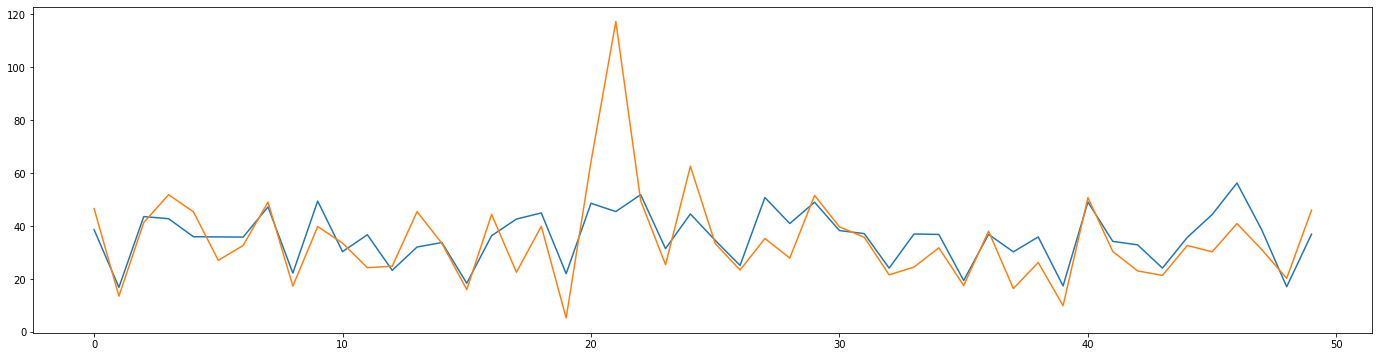

In [191]:
nbr = 50
pred = list(rf_delay.predict(X_test)[:nbr])
true = list(y_delay_test[:nbr])
plt.figure(figsize=(24,6))
plt.plot(range(nbr), pred)
plt.plot(range(nbr), true)